# Tile-Based Semantic Segmentation of Coffee Leaves

In this notebook, I want to dive deep into the semantic segmentation modeling used to detect defects on coffee leaves. Strictly speaking, the methodology I used is not actually "semantic segmentation" as modern deep learning models compute it. It is actually simple classification using a tile-based approach. I will still refer to it as semantic segmentation as it produces the same output (just not as efficiently).

In continuation from my previous notebook [Instance Segmentation with Mask R-CNN on Coffee Leaves](https://ainascan.com/blogs/instance-segmentation.html), we are taking the output of the Mask R-CNN model (the produced contour of each leaf) and classifying each pixel as either "defective" or "healthy".

Why would we do this and not just directly classify the whole image? Having a two layered approach is inefficent, but perhaps quite nessesary with this specific dataset. In the previous notebook, I had listed several references to techniques that "guided" a model to better detect diseases on leaves. You can review them here:

- [Detection and Classification of Coffee Leaf Disease using Deep Learning](https://www.researchgate.net/publication/366126688_Detection_and_Classification_of_Coffee_Leaf_Disease_using_Deep_Learning)

- [Coffee Disease Visualization and Classification](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8235481/)

Intuitively, this makes sense. CNN's aren't really good at "contextual" understanding. If a skilled researcher or farmer took a look at a picture of a coffee tree, they would have "context" that the grass on the ground, or the sky in the background, is not apart of a coffee leave (which is where the disease is going to be). A CNN model doesn't have that. But it is very good are detecting patterns. So good, that sometimes it's quite spooky.

A great reference to the explainability of CNN's can be found here: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/).

# Data Annotation

The main decision to use this "tile-based" semantic segmentation technique is the data annotation effort. Most modern approaches rely on painting a section of an image with a specific color (or label) to indicate that this pixels are different from other pixels. But this is very time consuming. Considering the high contextual dataset we are working with (even after "focusing" in on the leaves with the Mask R-CNN model) including but not limited to: lighting conditions, leaves of various sizes, shapes, ages, various defects, and various diseases, it would be very time consuming to annotate each pixel in the traditional way that captures all of these variations.

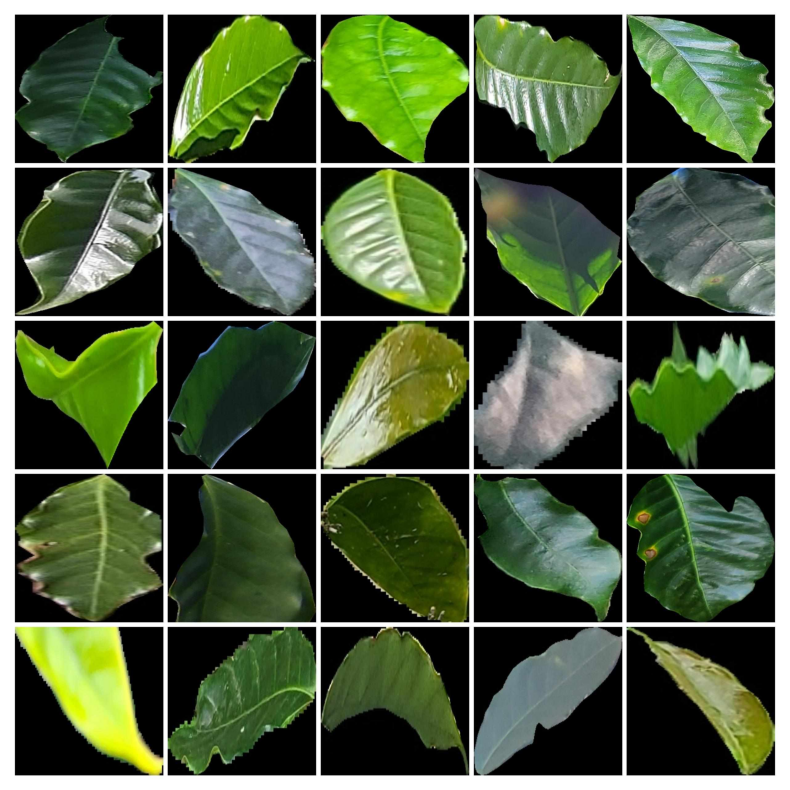

In [2]:
import cv2
import matplotlib.pyplot as plt

frame = cv2.imread('../images/mask_samples.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

However, if we can develop a tool that allows use to simply select a tile, (assuming a square) and classify the entire region as "defective" or "healthy", then we can (quite literally) reduce the annotation time by a factor of the square of the side length of the tile. In a 64x64 tile, we can classify 4096 pixels in one click. Amazing!

But before fully commiting to this approach, we need to understand it's limitations. Tile based approaches have been well tested and experimented with. In modern applications, they are used in very high resolution images, like satellite or drone imagery. They are mainly used due to memory limitations as the whole of a geographical survey cannot fit into memory. For smaller images, they are not used widely as memory is not a constraint an architectures (like Mask R-CNN or U-Net) are well studied and optimized for this task. But, in either high or low resolution images, the two biggest drawbacks are increased computation time and the loss of contextual information.

For a tile-based approach to work, and work accuracly, the tiles must overlap. If we classify a 64x64 tile as "defective" or "healthy", it may only contain a small portion of "defect" or "healthy" pixels. So, using a set stride, we move our tile region over the image and classify the next overlapping tile. This overlapping effect allows us to capture more context to the surrounding tiles and effectively "blend" the classification results together (we will get into this later). However, obviously, this increases computation time as we have to classify the same pixels multiple times over.

The loss of contextual information is also a bit obvious. Since we only feed in 64x64 pixels, can we really say whether or not a leaf is "defective" or "healthy"? If we feed in an entire image, and tile over it, we have proven that the model will not be able to distinguish between the leaf and the background (covered in the previous notebook). Considering the diversity of the dataset, a branch or shadow could easily produce a false positive.

The major caveat with our approach is that I'm already confident that a tile of 64x64 pixels, limited to the leaf region, should be able to classify a defective region. More diseases or defects are small and don't cover the entire leaf. And even if they do cover the entire leaf, they have very specific patterns that are distinguisable within a 64x64 pixel region.

For more insight into tile-based approaches and limitations, I highly recommend reading the following papers. The last being lecture notes with great visualizations:

- [Tiling and stitching segmentation output for remote sensing: basic challenges and recommendations](https://arxiv.org/pdf/1805.12219)

- [Insights into the Effects of Tile Size and Tile Overlap Levels on Semantic Segmentation Models Trained for Road Surface Area Extraction from Aerial Orthophotography](https://www.mdpi.com/2072-4292/16/16/2954)

- [Object Detection and Image Segmentation](https://cs231n.stanford.edu/slides/2022/lecture_9_jiajun.pdf)

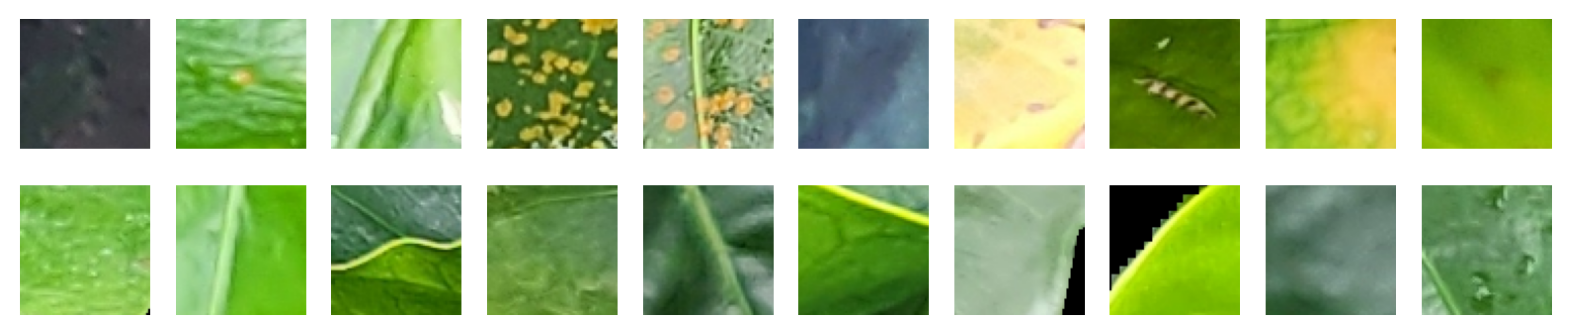

In [4]:
frame = cv2.imread('../images/patches.png')

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

With a quick OpenCV script, I was able to annotate a very large tiled dataset in a matter of a few hours. In the image above, the top row is "defective" tiles where as the bottom row is "healthy" tiles. A lot of tiles also contain "black" backgrounds as this is the result of masking the leaf region from the Mask R-CNN model. This is an undesirable effect, but hopefully a feature the model can learn to ignore (we will explore this later).

In [6]:
import os
import boto3
import deltalake as dl

os.environ['AWS_EC2_METADATA_DISABLED'] = 'true'

session = boto3.Session(profile_name='default')
credentials = session.get_credentials()
credentials = credentials.get_frozen_credentials()

storage_options = {
    'AWS_REGION': 'us-west-1',
    'AWS_ACCESS_KEY_ID': credentials.access_key,
    'AWS_SECRET_ACCESS_KEY': credentials.secret_key,
    'AWS_S3_ALLOW_UNSAFE_RENAME': 'true'
}
    
patch_annos = dl.DeltaTable(
    table_uri='s3a://coffee-dataset/lake/clear_leaf_patch_annotations',
    storage_options=storage_options
).to_pandas()

patch_annos

image_path  \
0      coffee-dataset/raw_images/bay_view_dead_leaves...   
1      coffee-dataset/raw_images/bay_view_dead_leaves...   
2      coffee-dataset/raw_images/bay_view_dead_leaves...   
3      coffee-dataset/raw_images/bay_view_dead_leaves...   
4      coffee-dataset/raw_images/bay_view_dead_leaves...   
...                                                  ...   
13341  coffee-dataset/raw_images/milolii_luis_farm/20...   
13342  coffee-dataset/raw_images/milolii_luis_farm/20...   
13343  coffee-dataset/raw_images/milolii_luis_farm/20...   
13344  coffee-dataset/raw_images/milolii_luis_farm/20...   
13345  coffee-dataset/raw_images/milolii_luis_farm/20...   

                                   hash  defective                 patch  
0      ec2785912ccfc157520dc7e44985fbd6          1   [230, 77, 294, 141]  
1      ec2785912ccfc157520dc7e44985fbd6          1   [179, 76, 243, 140]  
2      ec2785912ccfc157520dc7e44985fbd6          1   [115, 75, 179, 139]  
3      ec2785912ccfc157520dc7e44985fbd6          1    [62, 72, 126, 136]  
4      ec2785912ccfc157520dc7e44985fbd6          1    [99, 98, 163, 162]  
...                                 ...        ...                   ...  
13341  d36ae6fcc22a404233638f984e7b39b7          0  [500, 382, 564, 446]  
13342  d36ae6fcc22a404233638f984e7b39b7          0  [527, 304, 591, 368]  
13343  d36ae6fcc22a404233638f984e7b39b7          0  [600, 249, 664, 313]  
13344  d36ae6fcc22a404233638f984e7b39b7          0  [250, 102, 314, 166]  
13345  d36ae6fcc22a404233638f984e7b39b7          0   [175, 66, 239, 130]  

[13346 rows x 4 columns]

In [9]:
unique_images = patch_annos['image_path'].unique()

healthy_patches = patch_annos[patch_annos['defective'] == 0]
defective_patches = patch_annos[patch_annos['defective'] == 1]

print(f'Number of unique images: {len(unique_images)}')
print(f'Number of healthy patches: {len(healthy_patches)}')
print(f'Number of defective patches: {len(defective_patches)}')

Number of unique images: 192
Number of healthy patches: 8270
Number of defective patches: 5076


Now this dataset needs to be filtered a little bit (as it was easy to get click happy and annotate a lot of tiles). For removing some undesired tiles, I used a simple filter. If the tile is not contained at least 50% within the leaf region, it is removed. Additionally I check for all "black" tiles and tiles that somehow got malformed (like a 64x64 tile that is only 10x64).

```python
from shapely.geometry import Polygon

t = 64
polygon = Polygon(contour)

x1, y1, x2, y2 = patch
box = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])

greater_than_half = box.intersection(polygon).area / box.area >= 0.5
inside_polygon = polygon.contains(box)

if greater_than_half or inside_polygon:
    tile = mask[y1:y2, x1:x2]

    # if any size is less than t//2, skip
    if tile.shape[0] < t//2 or tile.shape[1] < t//2:
        continue

    # if tile is all black, skip
    if np.all(tile == 0):
        continue

    pads = ((0, t - tile.shape[0]), (0, t - tile.shape[1]), (0, 0))
    tile = np.pad(tile, pads, 'constant', constant_values=(0, 0))
    
    # save the tile to disk!
```

# Data Preprocessing And Augmentation

Now that we have our dataset, we need to consider it's balance. There are a lot more healthy regions than defective regions. This is expected as we are trying to detect and unwanted feature (most leaves are very healthy). Since it is quite easy to gather more data, we don't have to worry about generating synthetic data, or using SMOTE techniques. We can simply balance the dataset by removing some healthy tiles.

```python
df_majority = df[df['defective'] == 1]
df_minority = df[df['defective'] == 0]

if len(df_majority) < len(df_minority):
    df_majority, df_minority = df_minority, df_majority


df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=seed
)

# combine majority class with upsampled minority class
df = pd.concat([df_majority_downsampled, df_minority])

# set column 'sett' to be training, validation, or test
df['sett'] = np.random.choice(['train', 'val', 'test'], size=len(df), p=[0.7, 0.1, 0.2])
```

Data augmentation is a more interesting challenge.

In another notebook I did, I utilized very simple color based features to detect whether a leaf was defective or not: [Exploring Different Algorithms of Dominant Color Extraction](https://jackmead515.github.io/notebooks/exploring_dominant_colors.html). It was incredibly successful and I was able to classify leaves with 90% accuracy utilizing simple logistic regression. Given that the decision boundary is quite distiguishable on a linear scale with only colors, it's easy to transfer that intuition into our data augmentation strategy.

We shouldn't adjust the HUE of the leaf as this is a very defining feature of defects.

Defects generally take on various shapes and sizes, yes, but one of the most defining characteristics is the color. So, in our augmentation, we are only going to adjust the brightness and saturation. Throw in a bit of sharpness, blur, and rotationally flipping, and we have a very robust data augmentation strategy that will likely cover all the variations of defects.

```python
v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomAdjustSharpness(2.0),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
])
```

# Modeling

Now for the most exciting, but short lived, part: modeling! As with most computer vision applications, it's best to try well established models and build off of them. They usually have very good performance, are well studied by the community, are easy to implement, and usually have provided weights trained from ImageNet or COCO for transfer learnig. For our task, we make the assumption that capturing the difference between "defect" and "healthy" patches is highly differential so we don't need a very deep model. We also want something that is very fast to train and inference because we already know that tiling is going to be computationally expensive.

Some good models to try are ResNet-18, EfficientNet, and MobileNet as they are specifically optimized for speed (having fewer parameters then other flavors within their respective families). In Pytorch, it's quite easy to load these models and modify them to fit our task.

But in addition to this, since I already know that dominant colors have a huge influence in the classification of healthy and defective leaves, I also trained classical machine learning algorithms on this task to see how well they would perform in this task. Using an ensemble of XGBoost, with Niave Bayes to adjust the probability threshold, I was able to achieve 80% accuracy on the test set. Quite impressive! But more on this later.

In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class PatchModel(nn.Module):
    def __init__(self):
        super(PatchModel, self).__init__()
        
        # Load the EfficientNet-B0 model. It's default weights are being used for transfer learning.
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        # Freeze all the layers to increase the speed of training.
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze the last two layers and the classifier layer.
        # These layers will be optimized on our dataset during training.
        for param in self.model.features[-2:].parameters():
            param.requires_grad = True
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        # Modify the classifier layer to output a single value.
        # I also increase the dropout rate to 0.5 to prevent overfitting.
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 1)
        )

        # Move this model to the GPU!
        self.model = self.model.cuda().float()

    def forward(self, x):
        return self.model(x)

We can now setup our training loop. Since this is a two class problem, we can use binary cross entropy loss. Further, utilizing a sigmoid activation function on the output of the classifer will allow us to interpret the output as a probability. A super awesome description of the most often used activiation functions (softmax and sigmoid) can be found here: [Sigmoid and SoftMax Functions in 5 minutes](https://towardsdatascience.com/sigmoid-and-softmax-functions-in-5-minutes-f516c80ea1f9).

The output of our model classifier will actually be scalar whose range is quite large: ranging from negative to positive numbers. This can be interpreted as a probability by passing it through the sigmoid function whoses function is defined by:

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
```

Where the range will be restricted between 0 and 1 inclusive: effectively a probability!

We can trust in the Adam optimizer: a well established optimizer that is quite robust and requires very little tuning. We can also use the learning rate scheduler to reduce the learning rate as the model converges. This is a very common technique to ensure that the model converges to a local minimum without overshooting it. As the model gets closer to a minimum, the learning rate will decrease allowing the model to not "jump around" the minimum which is a common problem with gradient descent in neural networks.

Finally, since this is a classification problem, we'd also like to be able to track the ROC-AUC score (it's a mouthful: area under the curve of the receiver operating characteristic curve). This is a very common metric used in binary classification problems as it is can give insight into the model's ability to distinguish between the two classes. Google has a great article with awesome visualizations on the ROC curve: [Classification: ROC and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). The [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html) library also has incredible documentation on this: [TorchMetrics AUROC](https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html)

In [ ]:
import torch as t
import torch.nn as nn
from torchmetrics import AUROC

epochs = 60
learning_rate = 0.0008

model = PatchModel()

optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = t.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

loss_fn = nn.BCEWithLogitsLoss()

scaler = t.cuda.amp.GradScaler()

with t.autograd.set_detect_anomaly(False):
    
    for epoch in range(epochs):
            
        model.train()
        train_auc = AUROC(task='binary')
        running_loss = 0.0

        for masks, labels in train_dataset:
            masks, labels = masks.cuda(), labels.cuda()

            optimizer.zero_grad()
            with t.cuda.amp.autocast():
                output = model(masks).squeeze()
                labels = labels.float()
                loss = loss_fn(output, labels)
                train_auc.update(output, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            masks, labels = masks.cpu(), labels.cpu()
            
            running_loss += loss

        scheduler.step()
        
        train_auc = train_auc.compute()
        epoch_loss = running_loss / (len(train_dataset.dataset) / train_dataset.batch_size)

Similar code is using for the validation and test loop (without the backpropagation step). But we can now observe the model's performance.

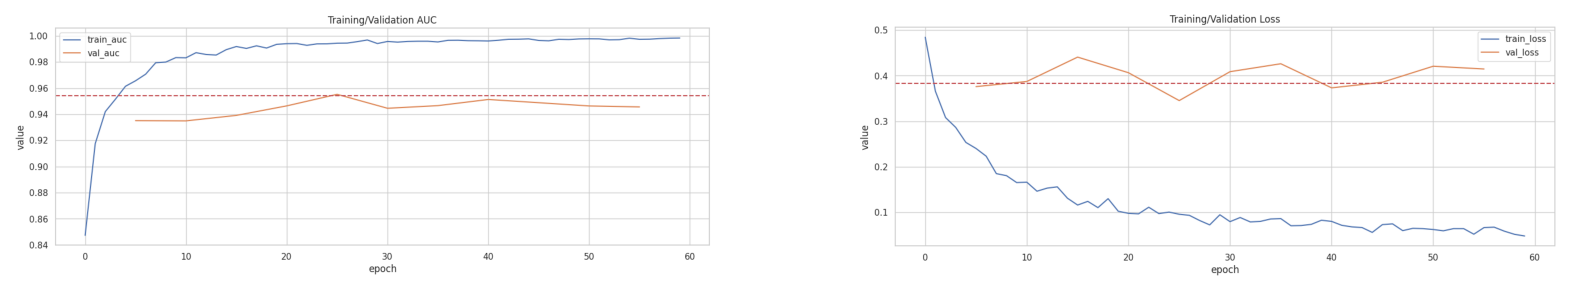

In [87]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread('../images/kina_metrics/kina_torch_auc.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cv2.imread('../images/kina_metrics/kina_torch_loss.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Very exciting! Breaking down the graphs, we can see that the model training AUC converges within the first 10 epochs. The validation AUC is quite a bit lower, and seems to only increase slightly up to about 95% around epoch 25. The loss is also interesting as the validation loss never seems to decrease. This could indicate the model is overfitting to the training data. But with a final test AUC of around 95%, we can't argue with the results too much. And upon looking at the confusion matrix, we can see that the model is quite balanced in it's predictions.

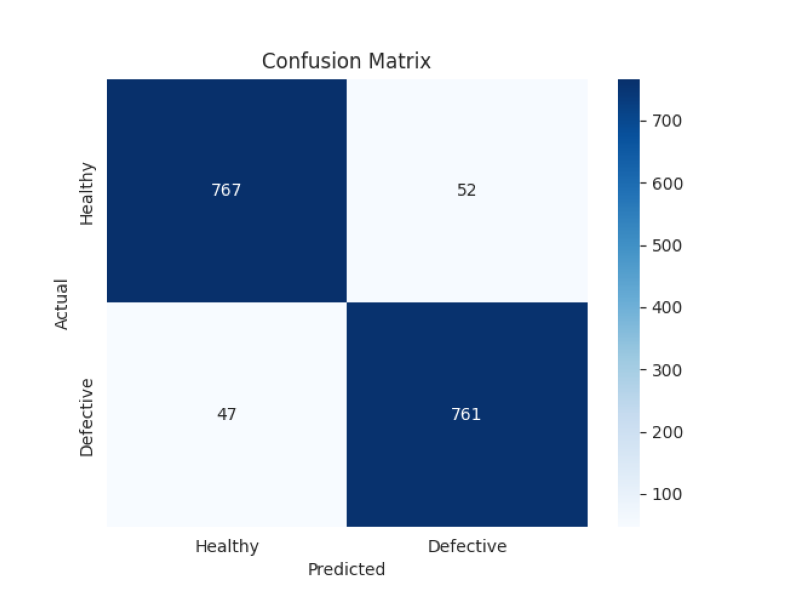

In [10]:
plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(cv2.imread('../images/kina_metrics/kina_torch_confusion_matrix.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Already we have an incredibly powerful model. Let's glance at the performance of the XGBoost model on dominant colors and see how it compares.

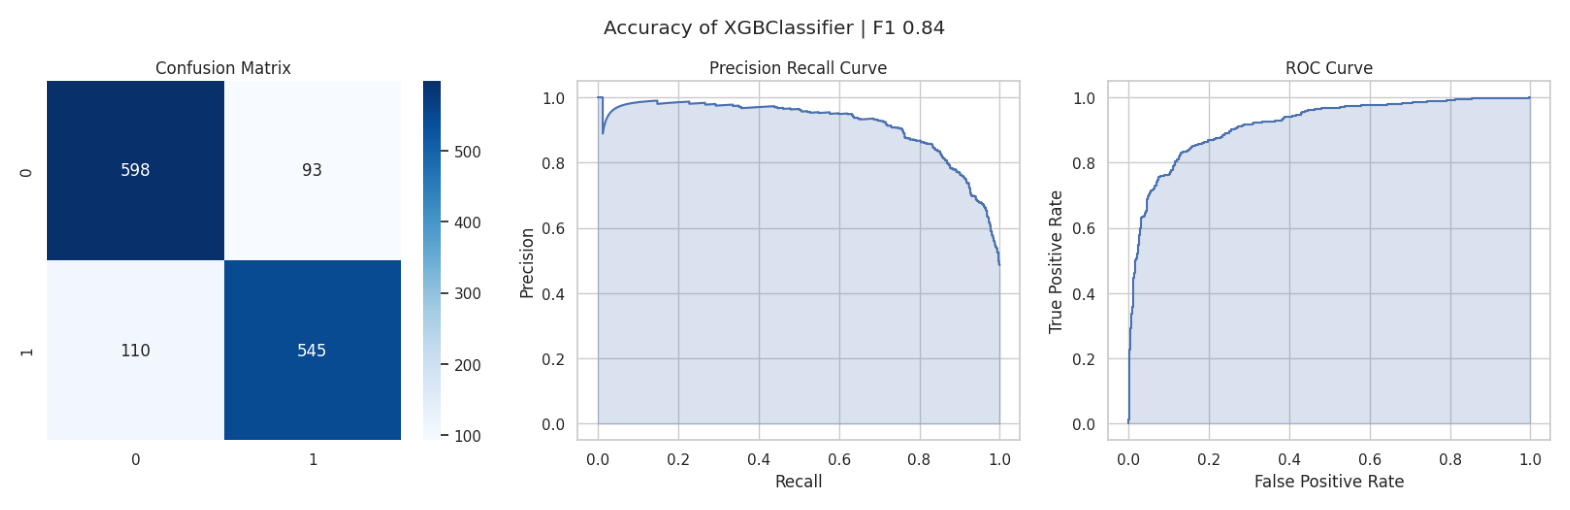

In [13]:
plt.figure(figsize=(20, 10))

plt.imshow(cv2.cvtColor(cv2.imread('../images/kina_metrics/color_xgb_metrics.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Still a remarkably impressive model on it's own, this model was trained on the top 64 dominant colors of each tile (4096 pixels of color down to 64 pixels essentially). Using a function like the one below. With an F1 score of 0.84, it's quite impressive. The real advantage of this comparison is to show how well a model can perform on a subset of features. It would certainly indicate a similar model exists that would perform better (given that our CNN seemed to overfit and a simpler model performs quite well). Adding more regularization, or even constructing our own CNN model from scratch could improve the performance.

In [ ]:
def dominant_colors(image_path):
    image = Image.open(image_path)
    paletted = image.convert('P', palette=Image.ADAPTIVE, colors=64)
    palette = paletted.getpalette()
    color_idxs = paletted.getcolors()
    colors = np.array([palette[idx*3:idx*3+3] for _, idx in color_idxs]) / 255
    colors = colors[np.argsort(np.linalg.norm(colors, axis=1))]
    colors = colors.flatten().tolist()
    colors += [0] * (192 - len(colors))
    return colors

# Tiling

Okay we have discussed a lot about the dataset and modeling for classification. But what does this got to do with semantic segmentation? For that, we need to go back to the tiling process. Since we assume that we will have a leaf mask from the Mask R-CNN model, we just using a static 64x64 tile and move it acrossed the mask at a set stride, and combine the resumes! Simple right? It takes a bit more involved math to understand how we "blend" these predictions together.

Our tiling function should is pretty straight-forward though.

In [ ]:
def extract_patches(mask, t=64, stride=8):
    coords, tiles = [], []
    
    for x in range(0, mask.shape[1] - t, stride):
        for y in range(0, mask.shape[0] - t, stride):
            tile = mask[y:y+t, x:x+t]
            coords.append([x, y])
            tiles.append(tile)

    return coords, tiles

coords, tiles = extract_patches(mask)

tiles = t.stack([t.tensor(tile, dtype=t.float32).permute(2, 0, 1) / 255.0 for tile in tiles])

predictions = t.sigmoid(model(tiles))

Blending these predictions together, we have to ensure they are normalized. On a 1D vector, we can visualize the blending process in the code below:

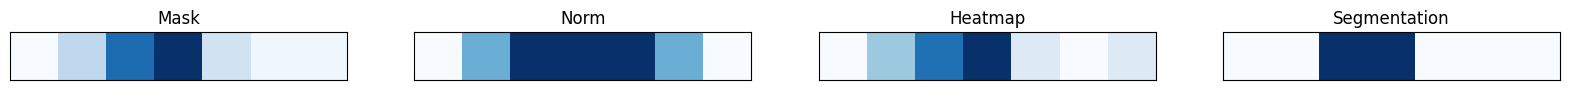

In [77]:
import numpy as np

t = 3
confidence = 0.5

# we are assuming a stride of 1 here.
# these are the probabilities of each pixel
# that we get from our fake model.
tiles = np.array([
    [0.1, 0.4, 0.7],
    [0.4, 0.7, 0.9],
    [0.7, 0.9, 0.2],
    [0.9, 0.2, 0.1],
    [0.2, 0.1, 0.2]
], dtype=np.float32)


mask = np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.float32)
norm = np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.float32)

for i in range(len(tiles)):
    p = tiles[i]

    # add the probabilities to the mask
    mask[i:i+t] += p
    
    # add the number of times that pixel has been added to the mask
    norm[i:i+t] += 1

# divide the mask by the number of times each pixel has been added to the mask
heatmap = mask / norm

# threshold the heatmap to get the segmentation
seg = (heatmap > confidence).astype(np.uint8)

mask_plot = (mask / mask.max() * 255).astype(np.uint8).reshape(1, -1)
norm_plot = (norm / norm.max() * 255).astype(np.uint8).reshape(1, -1)
heat_plot = (heatmap * 255).astype(np.uint8).reshape(1, -1)
seg_plot = (seg * 255).astype(np.uint8).reshape(1, -1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(mask_plot, cmap='Blues')
plt.xticks([]), plt.yticks([])
plt.title('Mask')
plt.subplot(1, 4, 2)
plt.imshow(norm_plot, cmap='Blues')
plt.xticks([]), plt.yticks([])
plt.title('Norm')
plt.subplot(1, 4, 3)
plt.imshow(heat_plot, cmap='Blues')
plt.xticks([]), plt.yticks([])
plt.title('Heatmap')
plt.subplot(1, 4, 4)
plt.imshow(seg_plot, cmap='Blues')
plt.xticks([]), plt.yticks([])
plt.title('Segmentation')
plt.show()

We essentially do the following:

- Sum up the probabilities of each pixel into an empty vector

- Sum up the number of times a pixel has been classified into an empty vector

- Divide the sum of probabilities by the sum of counts

- Threshold with whatever confidence we want to get the semantic segmentation mask

Dividing by the sum of probabilities by the sum of counts is also known as taking the <b>mean</b>!

In a 2D dimension, this is just as simple. And a querky library has been developed to do this for us: [PyTorch extensions for fast R&D prototyping and Kaggle farming](https://github.com/BloodAxe/pytorch-toolbelt). It combines the logic of the blending while also adding torch cuda support for GPU acceleration.

In [ ]:
from pytorch_toolbelt.inference.tiles import ImageSlicer, TileMerger
from pytorch_toolbelt.utils.torch_utils import to_numpy

t = 64
stride = 16
confidence = 0.5

tiler = ImageSlicer(mask.shape, tile_size=(t, t), tile_step=(stride, stride))
tiles = torch.stack([torch.tensor(tile, dtype=torch.float32).permute(2, 0, 1) / 255.0 for tile in tiler.split(mask)])

tiles = tiles.cuda()
merger = TileMerger(tiler.target_shape, 1, tiler.weight, device='cuda')

predictions = torch.sigmoid(model(tiles))

# perform the integration we saw above
merger.integrate_batch(predictions, tiler.crops)

# do the division! We have a heatmap now.
heatmap = np.moveaxis(to_numpy(merger.merge()), 0, -1)

# Our binary segmentation is just a thresholded version of the heatmap.
segmentation = (heatmap > confidence).astype(np.uint8)

Now, visualizing this, we can get a better understanding of varying the threshold of confidence.

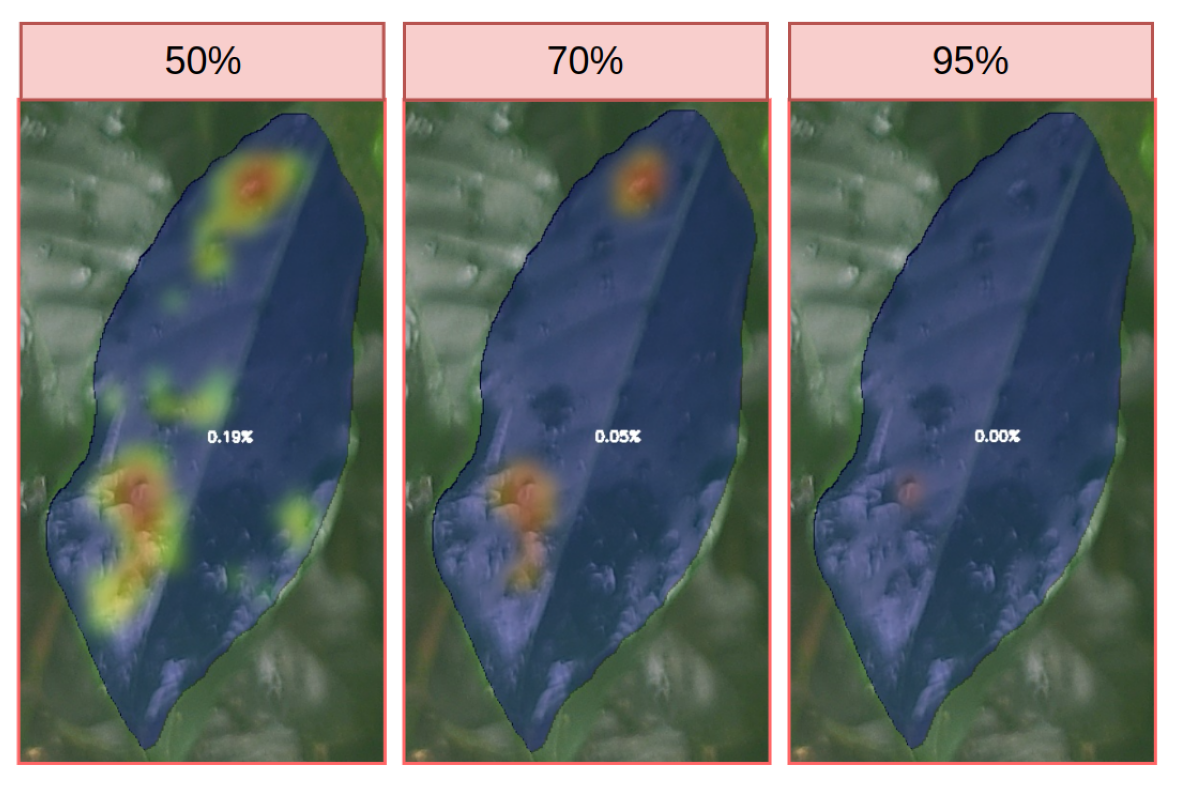

In [78]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(cv2.imread('../images/kina_threshold_comparison.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

And we finally have it! A fully working tile-based semantic segmentation model that can detect defects on coffee leaves.

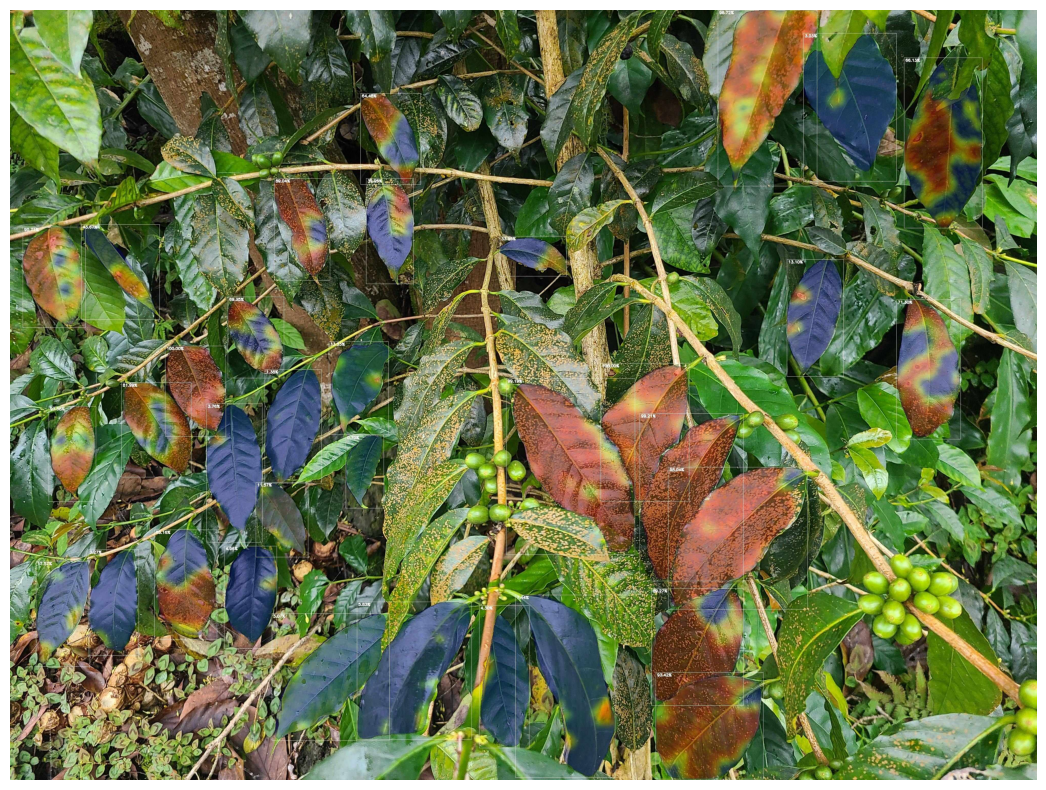

In [79]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(cv2.imread('../images/example_inferenced.jpg'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Conclusion

In this notebook, I have outlined a tile-based semantic segmentation method used to detect defects on coffee leaves. Due to the large time constraint of collecting data, this methodology proved to be faster to get an MVP than a traditional approach to annotation. Although, inferencing is slow, the model is able to achieve a 95% AUC on the test set.

Further, this model could actually be used to generate a dataset for a more traditional semantic segmentation model. By using our very accurate model, we can inference and generate the mask of many leaves and use this to feed to a U-Net model. This would be a very interesting experiment to see how well the two models compare.

I hope you enjoyed this notebook and learned something new.

# Citations

- Paulos, Eyobed & Woldeyohannis, Michael. (2022). Detection and Classification of Coffee Leaf Disease using Deep Learning. 1-6. 10.1109/ICT4DA56482.2022.9971300.

- Yebasse, Milkisa et al. “Coffee Disease Visualization and Classification.” Plants (Basel, Switzerland) vol. 10,6 1257. 21 Jun. 2021, doi:10.3390/plants10061257

- Olah, et al., "Feature Visualization", Distill, 2017. https://distill.pub/2017/feature-visualization/

- K. K. Singh, et al., "Tiling and stitching segmentation output for remote sensing: basic challenges and recommendations", arXiv, 2018. https://arxiv.org/pdf/1805.12219

- M. Niemeyer, "Insights into the Effects of Tile Size and Tile Overlap Levels on Semantic Segmentation Models Trained for Road Surface Area Extraction from Aerial Orthophotography", Remote Sensing, 2020. https://www.mdpi.com/2072-4292/16/16/2954

- Fei-Fei, L., et al., "Object Detection and Image Segmentation", Stanford, 2022. https://cs231n.stanford.edu/slides/2022/lecture_9_jiajun.pdf

- Tan, Mingxing, and Quoc Le. "Efficientnet: Rethinking model scaling for convolutional neural networks." International conference on machine learning. PMLR, 2019.

- He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

- Gabriel Furnieles, "Sigmoid and SoftMax Functions in 5 minutes", Towards Data Science, 2022. https://towardsdatascience.com/sigmoid-and-softmax-functions-in-5-minutes-f516c80ea1f9

- Google, "Classification: ROC and AUC", 2022. https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc